In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2_contingency
from scipy.stats import boxcox


In [2]:
df = pd.read_csv("restaurant_data.csv", index_col = 'Name')

In [3]:
df.head()

,Location,Cuisine,Rating,Seating Capacity,Average Meal Price,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Avg Review Length,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Revenue
Name,,,,,,,,,,,,,,,,
Restaurant 0,Rural,Japanese,4.0,38,73.98,2224,23406,13,185,161.924906,1.3,7.0,Yes,13,4,638945.52
Restaurant 1,Downtown,Mexican,3.2,76,28.11,4416,42741,8,533,148.759717,2.6,3.4,Yes,48,6,490207.83
Restaurant 2,Rural,Italian,4.7,48,48.29,2796,37285,18,853,56.849189,5.3,6.7,No,27,14,541368.62
Restaurant 3,Rural,Italian,4.4,34,51.55,1167,15214,13,82,205.433265,4.6,2.8,Yes,9,17,404556.80
Restaurant 4,Downtown,Japanese,4.9,88,75.98,3639,40171,9,78,241.681584,8.6,2.1,No,37,26,1491046.35


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8368 entries, Restaurant 0 to Restaurant 8367
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Location                8368 non-null   object 
 1   Cuisine                 8368 non-null   object 
 2   Rating                  8368 non-null   float64
 3   Seating Capacity        8368 non-null   int64  
 4   Average Meal Price      8368 non-null   float64
 5   Marketing Budget        8368 non-null   int64  
 6   Social Media Followers  8368 non-null   int64  
 7   Chef Experience Years   8368 non-null   int64  
 8   Number of Reviews       8368 non-null   int64  
 9   Avg Review Length       8368 non-null   float64
 10  Ambience Score          8368 non-null   float64
 11  Service Quality Score   8368 non-null   float64
 12  Parking Availability    8368 non-null   object 
 13  Weekend Reservations    8368 non-null   int64  
 14  Weekday Reservations   

In [5]:
df.duplicated().any()

False

In [6]:
df.isna().sum()

Location                  0
Cuisine                   0
Rating                    0
Seating Capacity          0
Average Meal Price        0
Marketing Budget          0
Social Media Followers    0
Chef Experience Years     0
Number of Reviews         0
Avg Review Length         0
Ambience Score            0
Service Quality Score     0
Parking Availability      0
Weekend Reservations      0
Weekday Reservations      0
Revenue                   0
dtype: int64

In [7]:

# A longer and higher-rated review may signal strong customer satisfaction.
df["Review Quality Score"] = df["Avg Review Length"] * df["Rating"]

# Price category
df["Meal Price Category"] = pd.cut(df["Average Meal Price"],
                                   bins=[0, 30, 60, 100],
                                   labels=["Low", "Medium", "High"])

# Drop unused/redundant columns
df.drop(columns=["Average Meal Price"], inplace=True)
df.drop(columns=["Avg Review Length"], inplace=True)
df.drop(columns=["Rating"], inplace=True)


In [8]:
X = df.drop('Revenue',axis=1)
Y = df['Revenue']

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3, random_state=1000)

In [10]:
y_test.shape

(2511,)

In [11]:
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [12]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['Rural', 'Suburban', 'Downtown']])
X_train[['Location']] = encoder.fit_transform(X_train[['Location']])
X_train['Location'] = X_train['Location'].astype(int)

encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
X_train[["Meal Price Category"]] = encoder.fit_transform(X_train[["Meal Price Category"]])
X_train["Meal Price Category"] = X_train["Meal Price Category"].astype(int)

In [13]:
X_train.head()

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category
Name,,,,,,,,,,,,,,
Restaurant 1649,0,Japanese,49,3259,34243,6,109,4.2,5.5,Yes,24,11,810.583476,2
Restaurant 1052,1,Indian,55,2662,34744,4,826,1.8,4.6,Yes,27,24,500.508350,1
Restaurant 2520,1,Italian,60,1515,19829,13,207,8.5,3.5,Yes,44,51,699.115449,1
Restaurant 5818,2,Italian,90,5031,58655,13,805,3.5,9.6,Yes,86,29,817.414508,1
Restaurant 1727,0,Italian,35,1778,24218,1,234,5.6,5.8,No,0,7,576.446525,1


## Cluster Analysis

In [15]:
# Load data
data = X_train

In [16]:
data.head()

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category
Name,,,,,,,,,,,,,,
Restaurant 1649,0,Japanese,49,3259,34243,6,109,4.2,5.5,Yes,24,11,810.583476,2
Restaurant 1052,1,Indian,55,2662,34744,4,826,1.8,4.6,Yes,27,24,500.508350,1
Restaurant 2520,1,Italian,60,1515,19829,13,207,8.5,3.5,Yes,44,51,699.115449,1
Restaurant 5818,2,Italian,90,5031,58655,13,805,3.5,9.6,Yes,86,29,817.414508,1
Restaurant 1727,0,Italian,35,1778,24218,1,234,5.6,5.8,No,0,7,576.446525,1


In [19]:
data.shape

(5857, 14)

In [34]:
# Specify categorical columns (by name or index)
categorical_cols = ['Cuisine', 'Parking Availability']  
ordinal_categorical = ['Location', 'Meal Price Category','Cuisine', 'Parking Availability']
numerical_cols = [col for col in data.columns if col not in ordinal_categorical]

# Convert categorical columns to strings (required for K-Prototypes)
data[categorical_cols] = data[categorical_cols].astype(str)

# Scale numerical features (critical for distance calculations)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Get categorical column indices
categorical_idx = [data.columns.get_loc(col) for col in categorical_cols]



In [36]:
categorical_idx

[1, 9]

In [38]:
# Convert dataframe to matrix
dfMatrix = data.to_numpy()

## K-Prototype Clustering

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6


<function matplotlib.pyplot.show(close=None, block=None)>

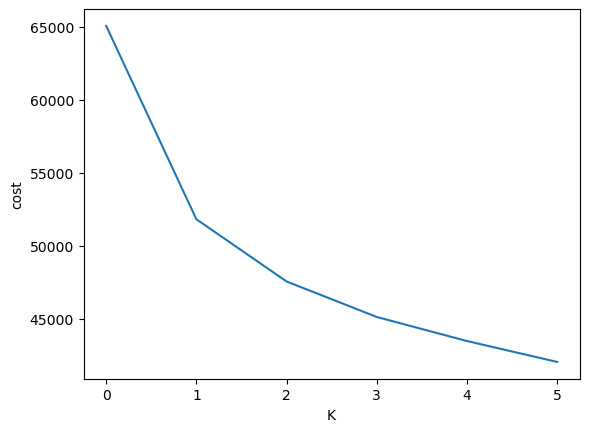

In [43]:
#Elbow method to detect number of K
from kmodes.kprototypes import KPrototypes

cost = []
for cluster in range(1, 7):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 42,gamma=0.1)
        kprototype.fit_predict(dfMatrix, categorical = categorical_idx)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

K=2, Silhouette Score=0.1997
K=3, Silhouette Score=0.1206
K=4, Silhouette Score=0.0762
K=5, Silhouette Score=0.0741
K=6, Silhouette Score=0.0631


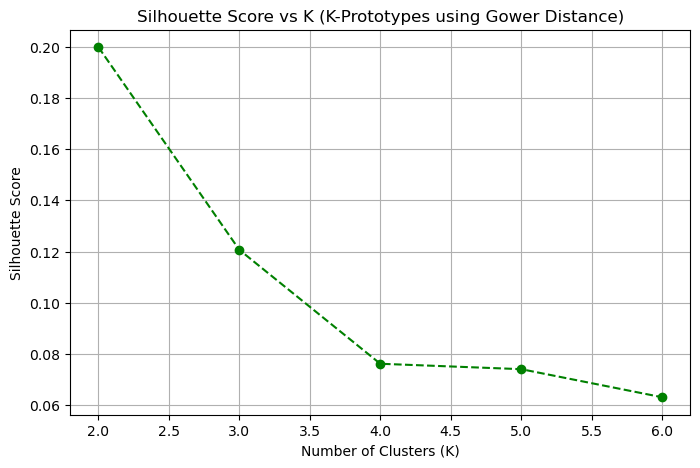

In [51]:
!pip install gower

import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
import gower

# Store silhouette scores
silhouette_scores = []

# Range of clusters
for k in range(2, 7):  # silhouette needs at least 2 clusters
    try:
        # Fit KPrototypes
        kproto = KPrototypes(n_jobs=-1, n_clusters=k, init='Huang', random_state=42, gamma=0.1)
        clusters = kproto.fit_predict(dfMatrix, categorical=categorical_idx)

        # Compute Gower distance matrix
        gower_dist = gower.gower_matrix(dfMatrix)

        # Compute silhouette score using Gower distance
        score = silhouette_score(gower_dist, clusters, metric='precomputed')
        silhouette_scores.append(score)
        print(f"K={k}, Silhouette Score={score:.4f}")
    except Exception as e:
        print(f"Failed for K={k}: {e}")
        break

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 2 + len(silhouette_scores)), silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Silhouette Score vs K (K-Prototypes using Gower Distance)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


### Find Optimal Clusters

In [57]:
# cost (sum distance): confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concave, will detect knees
from kneed import KneeLocator
cost_knee_c3 = KneeLocator(
        x=range(1,7), 
        y=cost, 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow   
print("elbow at k =", f'{K_cost_c3:.0f} clusters')

elbow at k = 2 clusters


Text(0.5, 1.0, 'Gamma Tuning Curve')

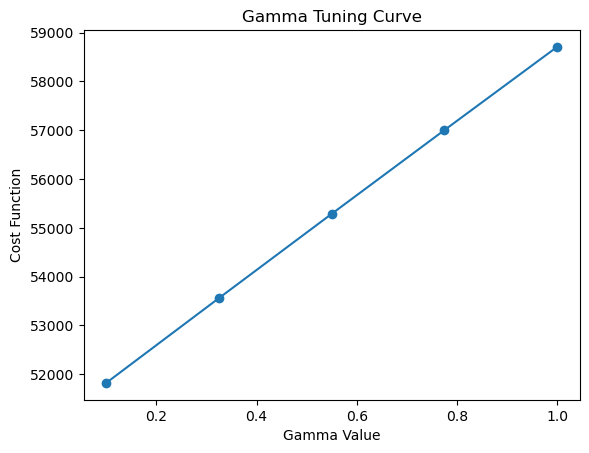

In [58]:
from kmodes.kprototypes import KPrototypes

# Test gamma values
gammas = np.linspace(0.1, 1.0, 5)
costs = []

for gamma in gammas:
    kproto = KPrototypes(n_clusters=2, gamma=gamma, init='Cao')
    kproto.fit(dfMatrix, categorical=[1, 9])  
    costs.append(kproto.cost_)

# Plot results
plt.plot(gammas, costs, marker='o')
plt.xlabel('Gamma Value')
plt.ylabel('Cost Function')
plt.title('Gamma Tuning Curve')

In [60]:
# Find the index of the minimum cost
min_index = np.argmin(costs)

# Get the gamma and cost at that index
best_gamma = gammas[min_index]
lowest_cost = costs[min_index]

print(f"Lowest cost is {lowest_cost} at gamma = {best_gamma}")

Lowest cost is 51823.491744689505 at gamma = 0.1


In [61]:
#let's build the Kprototype model with 2 clusters
kprototype = KPrototypes(n_jobs = -1, n_clusters = 2, init = 'Huang', random_state = 3003,gamma=0.1)
data['clusters']= kprototype.fit_predict(dfMatrix, categorical = categorical_idx)


In [62]:
kprototype

KPrototypes(gamma=0.1, init='Huang', n_clusters=2, n_jobs=-1, random_state=3003)

In [63]:
data['clusters']

Name
Restaurant 1649    1
Restaurant 1052    1
Restaurant 2520    1
Restaurant 5818    0
Restaurant 1727    1
                  ..
Restaurant 769     1
Restaurant 2398    1
Restaurant 3776    1
Restaurant 6215    1
Restaurant 4695    1
Name: clusters, Length: 5857, dtype: uint16

In [64]:
#predict the labels of clusters.
label = kprototype.fit_predict(dfMatrix, categorical = categorical_idx)
print(label)

[1 1 1 ... 1 1 1]


In [65]:
data.head()

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category,clusters
Name,,,,,,,,,,,,,,,
Restaurant 1649,0,Japanese,-0.634164,0.022924,-0.106408,-0.722542,-1.504662,-0.520297,0.012226,Yes,-0.278235,-0.919097,0.348328,2,1
Restaurant 1052,1,Indian,-0.288299,-0.305758,-0.079374,-1.085253,1.084756,-1.454932,-0.335381,Yes,-0.127228,-0.265472,-0.655155,1,1
Restaurant 2520,1,Italian,-0.000079,-0.937244,-0.884174,0.546946,-1.150739,1.154258,-0.760234,Yes,0.728483,1.092055,-0.012411,1,1
Restaurant 5818,2,Italian,1.729245,0.998507,1.210842,0.546946,1.008916,-0.792899,1.595768,Yes,2.842591,-0.014078,0.370435,1,0
Restaurant 1727,0,Italian,-1.441182,-0.792448,-0.647348,-1.629319,-1.053229,0.024907,0.128095,No,-1.486297,-1.120212,-0.409400,1,1


In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import davies_bouldin_score
from kmodes.kprototypes import KPrototypes

# Convert your original DataFrame into a version with all numeric data
df_encoded = data.copy()

# Replace categorical columns with label encoded values
label_encoders = {}
for idx in categorical_idx:
    col = df.columns[idx]
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Fit K-Prototypes on the original mixed data
kproto = KPrototypes(n_clusters=2, init='Huang', random_state=3003)
clusters = kproto.fit_predict(dfMatrix, categorical=categorical_idx)

# Now compute Davies–Bouldin Index on the fully numeric version
dbi = davies_bouldin_score(df_encoded, clusters)
print(f"Davies–Bouldin Index: {dbi:.3f}")


Davies–Bouldin Index: 2.077


In [74]:
data.head()

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category,clusters
Name,,,,,,,,,,,,,,,
Restaurant 1649,0,Japanese,-0.634164,0.022924,-0.106408,-0.722542,-1.504662,-0.520297,0.012226,Yes,-0.278235,-0.919097,0.348328,2,1
Restaurant 1052,1,Indian,-0.288299,-0.305758,-0.079374,-1.085253,1.084756,-1.454932,-0.335381,Yes,-0.127228,-0.265472,-0.655155,1,1
Restaurant 2520,1,Italian,-0.000079,-0.937244,-0.884174,0.546946,-1.150739,1.154258,-0.760234,Yes,0.728483,1.092055,-0.012411,1,1
Restaurant 5818,2,Italian,1.729245,0.998507,1.210842,0.546946,1.008916,-0.792899,1.595768,Yes,2.842591,-0.014078,0.370435,1,0
Restaurant 1727,0,Italian,-1.441182,-0.792448,-0.647348,-1.629319,-1.053229,0.024907,0.128095,No,-1.486297,-1.120212,-0.409400,1,1


In [76]:
dfMatrix = data.to_numpy()

### Clustering Data Set

In [117]:
# Initialize encoder (sparse=False is no longer needed)
encoder = OneHotEncoder(drop='first')  # drop='first' reduces multicollinearity

# Fit and transform
encoded_cats = encoder.fit_transform(data[categorical_cols])

# Convert to DataFrame (automatically handles sparse matrices)
encoded_df = pd.DataFrame.sparse.from_spmatrix(
    encoded_cats,
    columns=encoder.get_feature_names_out()
)

# Combine with numerical features
comb_df = pd.concat([
    data[numerical_cols].reset_index(drop=True),
    encoded_df
], axis=1)

In [119]:
comb_df.head()

,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Weekend Reservations,Weekday Reservations,Review Quality Score,Cuisine_French,Cuisine_Indian,Cuisine_Italian,Cuisine_Japanese,Cuisine_Mexican,Parking Availability_Yes
0,-0.634164,0.022924,-0.106408,-0.722542,-1.504662,-0.520297,0.012226,-0.278235,-0.919097,0.348328,0,0,0,1.0,0,1.0
1,-0.288299,-0.305758,-0.079374,-1.085253,1.084756,-1.454932,-0.335381,-0.127228,-0.265472,-0.655155,0,1.0,0,0,0,1.0
2,-0.000079,-0.937244,-0.884174,0.546946,-1.150739,1.154258,-0.760234,0.728483,1.092055,-0.012411,0,0,1.0,0,0,1.0
3,1.729245,0.998507,1.210842,0.546946,1.008916,-0.792899,1.595768,2.842591,-0.014078,0.370435,0,0,1.0,0,0,1.0
4,-1.441182,-0.792448,-0.647348,-1.629319,-1.053229,0.024907,0.128095,-1.486297,-1.120212,-0.409400,0,0,1.0,0,0,0


In [121]:

comb_df['Location'] = data['Location'].values
comb_df['Meal Price Category'] = data['Meal Price Category'].values

In [123]:
comb_df.head()

,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Weekend Reservations,Weekday Reservations,Review Quality Score,Cuisine_French,Cuisine_Indian,Cuisine_Italian,Cuisine_Japanese,Cuisine_Mexican,Parking Availability_Yes,Location,Meal Price Category
0,-0.634164,0.022924,-0.106408,-0.722542,-1.504662,-0.520297,0.012226,-0.278235,-0.919097,0.348328,0,0,0,1.0,0,1.0,0,2
1,-0.288299,-0.305758,-0.079374,-1.085253,1.084756,-1.454932,-0.335381,-0.127228,-0.265472,-0.655155,0,1.0,0,0,0,1.0,1,1
2,-0.000079,-0.937244,-0.884174,0.546946,-1.150739,1.154258,-0.760234,0.728483,1.092055,-0.012411,0,0,1.0,0,0,1.0,1,1
3,1.729245,0.998507,1.210842,0.546946,1.008916,-0.792899,1.595768,2.842591,-0.014078,0.370435,0,0,1.0,0,0,1.0,2,1
4,-1.441182,-0.792448,-0.647348,-1.629319,-1.053229,0.024907,0.128095,-1.486297,-1.120212,-0.409400,0,0,1.0,0,0,0,0,1


### Detect outliers

In [126]:
from sklearn.ensemble import IsolationForest

# Initialize the model
iso_forest = IsolationForest(contamination=0.01, random_state=3003)

# Fit and predict
outlier_labels = iso_forest.fit_predict(comb_df)

# Add predictions to DataFrame
comb_df['IF_Outlier'] = outlier_labels


In [128]:
comb_df

,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Weekend Reservations,Weekday Reservations,Review Quality Score,Cuisine_French,Cuisine_Indian,Cuisine_Italian,Cuisine_Japanese,Cuisine_Mexican,Parking Availability_Yes,Location,Meal Price Category,IF_Outlier
0,-0.634164,0.022924,-0.106408,-0.722542,-1.504662,-0.520297,0.012226,-0.278235,-0.919097,0.348328,0,0,0,1.0,0,1.0,0,2,1
1,-0.288299,-0.305758,-0.079374,-1.085253,1.084756,-1.454932,-0.335381,-0.127228,-0.265472,-0.655155,0,1.0,0,0,0,1.0,1,1,1
2,-0.000079,-0.937244,-0.884174,0.546946,-1.150739,1.154258,-0.760234,0.728483,1.092055,-0.012411,0,0,1.0,0,0,1.0,1,1,1
3,1.729245,0.998507,1.210842,0.546946,1.008916,-0.792899,1.595768,2.842591,-0.014078,0.370435,0,0,1.0,0,0,1.0,2,1,1
4,-1.441182,-0.792448,-0.647348,-1.629319,-1.053229,0.024907,0.128095,-1.486297,-1.120212,-0.409400,0,0,1.0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,-1.268250,-0.711517,-0.908618,-1.629319,0.246897,-0.753956,0.205341,-0.680923,0.136758,-0.913640,0,0,0,1.0,0,1.0,0,2,1
5853,0.461074,-0.204456,-0.143208,1.635079,-0.894325,0.141737,-1.687185,1.533857,-1.472163,0.570027,1.0,0,0,0,0,0,1,1,1
5854,0.576363,-0.383386,-0.516767,-0.359831,-1.360204,0.102793,-1.107840,0.023780,1.795958,-1.447547,0,0,1.0,0,0,0,1,1,1
5855,-1.210605,-1.111770,-1.124076,0.546946,-1.515497,-0.637126,1.595768,-0.429243,-0.868818,0.735000,0,0,1.0,0,0,0,0,1,1


In [130]:
num_outliers = (comb_df['IF_Outlier'] == -1).sum()
print(f"Number of outliers detected: {num_outliers}")


Number of outliers detected: 59


In [132]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# Fit the model and predict outliers
outlier_labels = lof.fit_predict(comb_df)

# LOF returns 1 for normal points and -1 for outliers
comb_df['LOF_Outlier'] = outlier_labels

# Convert to more intuitive format (0 for normal, 1 for outliers)
comb_df['LOF_Outlier'] = comb_df['LOF_Outlier'].apply(lambda x: 1 if x == -1 else 0)

# Output the first few rows to check
print(comb_df[['LOF_Outlier']].head())

# Count the number of outliers (where LOF_Outlier is 1)
outlier_count = comb_df['LOF_Outlier'].sum()

# Print the count of outliers
print(f"Number of outliers detected: {outlier_count}")


   LOF_Outlier
0            0
1            0
2            0
3            0
4            0
Number of outliers detected: 59


In [138]:
comb_df['clusters'] = data['clusters'].values
comb_df.drop(columns=["IF_Outlier"], inplace=True)
comb_df.drop(columns=["LOF_Outlier"], inplace=True)

In [139]:
comb_df

,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Weekend Reservations,Weekday Reservations,Review Quality Score,Cuisine_French,Cuisine_Indian,Cuisine_Italian,Cuisine_Japanese,Cuisine_Mexican,Parking Availability_Yes,Location,Meal Price Category,clusters
0,-0.634164,0.022924,-0.106408,-0.722542,-1.504662,-0.520297,0.012226,-0.278235,-0.919097,0.348328,0,0,0,1.0,0,1.0,0,2,1
1,-0.288299,-0.305758,-0.079374,-1.085253,1.084756,-1.454932,-0.335381,-0.127228,-0.265472,-0.655155,0,1.0,0,0,0,1.0,1,1,1
2,-0.000079,-0.937244,-0.884174,0.546946,-1.150739,1.154258,-0.760234,0.728483,1.092055,-0.012411,0,0,1.0,0,0,1.0,1,1,1
3,1.729245,0.998507,1.210842,0.546946,1.008916,-0.792899,1.595768,2.842591,-0.014078,0.370435,0,0,1.0,0,0,1.0,2,1,0
4,-1.441182,-0.792448,-0.647348,-1.629319,-1.053229,0.024907,0.128095,-1.486297,-1.120212,-0.409400,0,0,1.0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,-1.268250,-0.711517,-0.908618,-1.629319,0.246897,-0.753956,0.205341,-0.680923,0.136758,-0.913640,0,0,0,1.0,0,1.0,0,2,1
5853,0.461074,-0.204456,-0.143208,1.635079,-0.894325,0.141737,-1.687185,1.533857,-1.472163,0.570027,1.0,0,0,0,0,0,1,1,1
5854,0.576363,-0.383386,-0.516767,-0.359831,-1.360204,0.102793,-1.107840,0.023780,1.795958,-1.447547,0,0,1.0,0,0,0,1,1,1
5855,-1.210605,-1.111770,-1.124076,0.546946,-1.515497,-0.637126,1.595768,-0.429243,-0.868818,0.735000,0,0,1.0,0,0,0,0,1,1


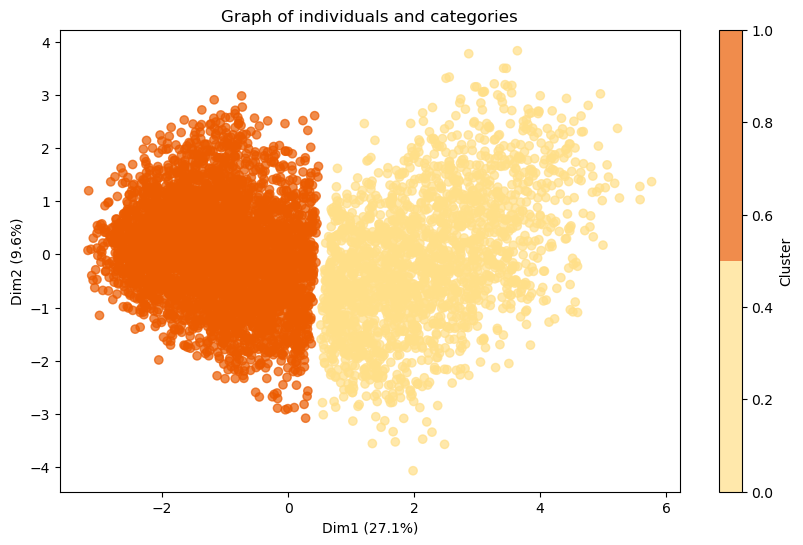

In [142]:
# Apply PCA
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Custom colors for 2 clusters
custom_cmap = ListedColormap(['#FFDF88', '#EB5B00'])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(comb_df)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(
    pca_result[:,0], pca_result[:,1],
    c=comb_df['clusters'],
    cmap=custom_cmap,
    alpha=0.7
)
plt.title('Graph of individuals and categories')
plt.xlabel(f'Dim1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'Dim2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.colorbar(label='Cluster')
plt.show()

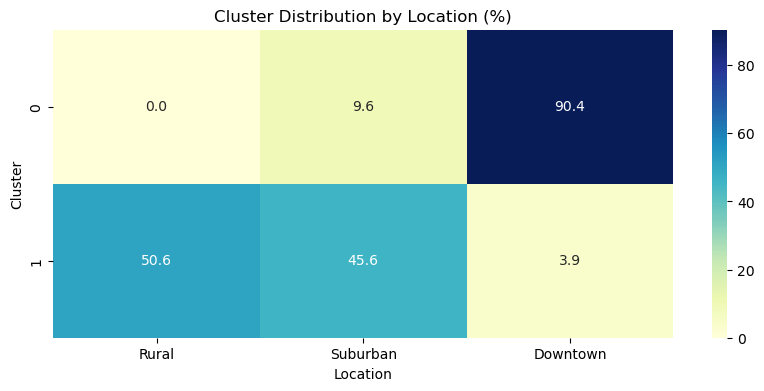

In [143]:
# Example data (you would use your actual data here)
# data = your_dataframe

# Create contingency table
ct = pd.crosstab(data['clusters'], data['Location'], normalize='index') * 100

# Rename the columns to reflect the actual location names
ct.columns = ['Rural', 'Suburban', 'Downtown']

# Visualize
plt.figure(figsize=(10, 4))
sns.heatmap(ct, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Cluster Distribution by Location (%)")
plt.ylabel("Cluster")
plt.xlabel("Location")
plt.show()

In [146]:
#Map the clusters to 'nonurban' and 'urban'
data['clusters'] = data['clusters'].map({0: 'urban', 1: 'nonurban'})


Location vs Cluster: p-value = 0.0000


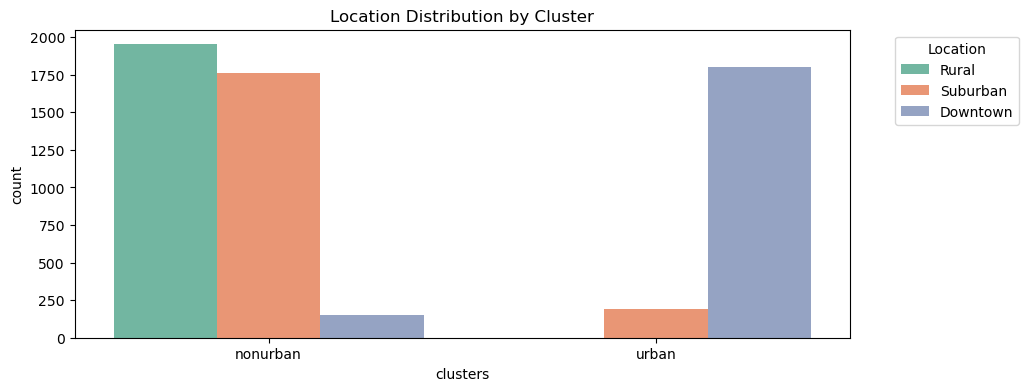

Meal Price Category vs Cluster: p-value = 0.6519


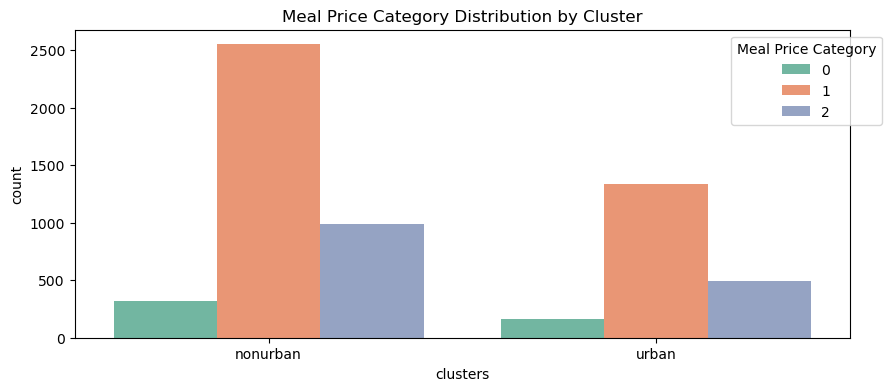

Cuisine vs Cluster: p-value = 0.3442


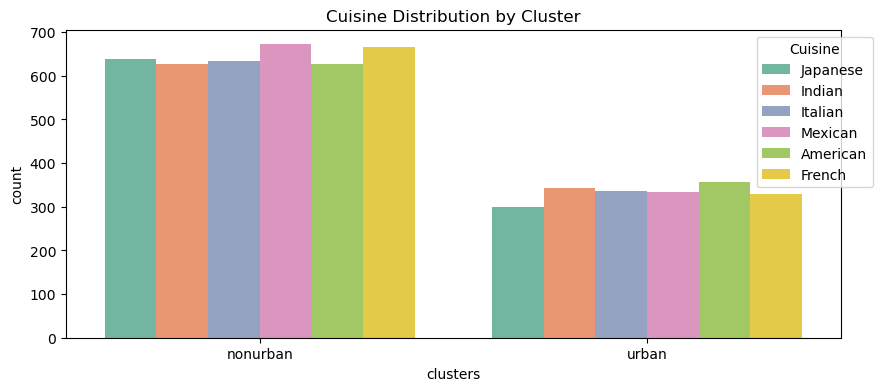

Parking Availability vs Cluster: p-value = 0.6443


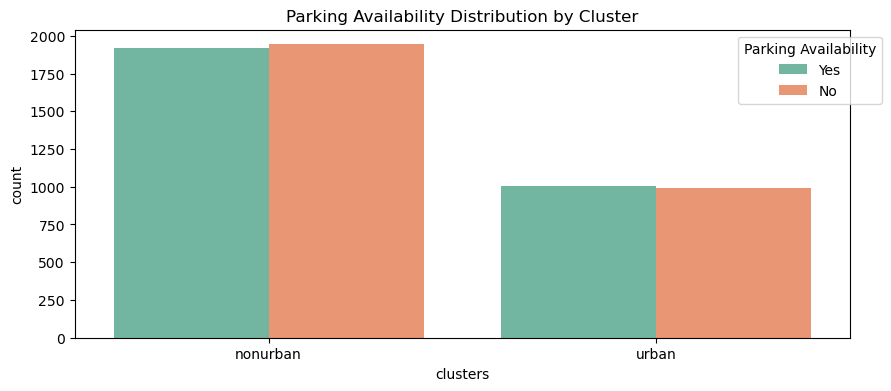

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency

# Define mapping for the Location variable
location_mapping = {0: "Rural", 1: "Suburban", 2: "Downtown"}

# For each categorical variable
for cat_var in ordinal_categorical:
    plt.figure(figsize=(10, 4))
    ax = sns.countplot(data=data, x='clusters', hue=cat_var, palette='Set2')

    # Get unique category values
    handles, labels = ax.get_legend_handles_labels()
    
    # If the variable is 'Location', map the numeric labels to original names
    if cat_var == "Location":
        labels = [location_mapping[int(label)] for label in labels]

    plt.legend(handles, labels, title=cat_var, bbox_to_anchor=(1.05, 1))
    plt.title(f'{cat_var} Distribution by Cluster')

    # Chi-square test
    crosstab = pd.crosstab(data['clusters'], data[cat_var])
    chi2, p, _, _ = chi2_contingency(crosstab)
    print(f"{cat_var} vs Cluster: p-value = {p:.4f}")

    plt.show()


In [150]:
## Cramers'V test

def cramers_v(confusion_matrix):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min((k-1), (r-1)))

# Calculate for all categorical variables
results = []
for cat_var in ordinal_categorical:
    crosstab = pd.crosstab(data['clusters'], data[cat_var])
    v = cramers_v(crosstab.values)
    results.append({'Variable': cat_var, "Cramér's V": v})
    
# Create results dataframe
cramer_results = pd.DataFrame(results).sort_values("Cramér's V", ascending=False)
print(cramer_results)

               Variable  Cramér's V
0              Location    0.873975
2               Cuisine    0.030996
1   Meal Price Category    0.012087
3  Parking Availability    0.006033


## Divide dataset into two cluster

In [153]:
y_train = pd.DataFrame(y_train) 
y_train['clusters'] = data['clusters'] 
y_train

,Revenue,clusters
Name,,
Restaurant 1649,794650.87,nonurban
Restaurant 1052,421854.52,nonurban
Restaurant 2520,659678.50,nonurban
Restaurant 5818,958061.50,urban
Restaurant 1727,358587.50,nonurban
...,...,...
Restaurant 769,615576.80,nonurban
Restaurant 2398,926123.05,nonurban
Restaurant 3776,741198.15,nonurban


In [155]:
df = pd.read_csv('X_train.csv')
df['clusters'] = data['clusters'].values
df['Revenue'] = y_train['Revenue'].values


In [157]:
df

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category,clusters,Revenue
0,Rural,Japanese,49,3259,34243,6,109,4.2,5.5,Yes,24,11,810.583476,High,nonurban,794650.87
1,Suburban,Indian,55,2662,34744,4,826,1.8,4.6,Yes,27,24,500.508350,Medium,nonurban,421854.52
2,Suburban,Italian,60,1515,19829,13,207,8.5,3.5,Yes,44,51,699.115449,Medium,nonurban,659678.50
3,Downtown,Italian,90,5031,58655,13,805,3.5,9.6,Yes,86,29,817.414508,Medium,urban,958061.50
4,Rural,Italian,35,1778,24218,1,234,5.6,5.8,No,0,7,576.446525,Medium,nonurban,358587.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,Rural,Japanese,38,1925,19376,1,594,3.6,6.0,Yes,16,32,420.636825,High,nonurban,615576.80
5853,Suburban,French,68,2846,33561,19,278,5.9,1.1,No,60,0,879.088122,Medium,nonurban,926123.05
5854,Suburban,Italian,70,2521,26638,8,149,5.8,2.6,No,30,65,255.660252,Medium,nonurban,741198.15
5855,Rural,Italian,39,1198,15383,13,106,3.9,9.6,No,21,12,930.064661,Medium,nonurban,451999.81


In [159]:
# Split into two DataFrames based on cluster column


df['clusters'] = df['Location'].apply(lambda x: 'nonurban' if x in ['Suburban', 'Rural'] else 'urban')



In [161]:
df

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category,clusters,Revenue
0,Rural,Japanese,49,3259,34243,6,109,4.2,5.5,Yes,24,11,810.583476,High,nonurban,794650.87
1,Suburban,Indian,55,2662,34744,4,826,1.8,4.6,Yes,27,24,500.508350,Medium,nonurban,421854.52
2,Suburban,Italian,60,1515,19829,13,207,8.5,3.5,Yes,44,51,699.115449,Medium,nonurban,659678.50
3,Downtown,Italian,90,5031,58655,13,805,3.5,9.6,Yes,86,29,817.414508,Medium,urban,958061.50
4,Rural,Italian,35,1778,24218,1,234,5.6,5.8,No,0,7,576.446525,Medium,nonurban,358587.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,Rural,Japanese,38,1925,19376,1,594,3.6,6.0,Yes,16,32,420.636825,High,nonurban,615576.80
5853,Suburban,French,68,2846,33561,19,278,5.9,1.1,No,60,0,879.088122,Medium,nonurban,926123.05
5854,Suburban,Italian,70,2521,26638,8,149,5.8,2.6,No,30,65,255.660252,Medium,nonurban,741198.15
5855,Rural,Italian,39,1198,15383,13,106,3.9,9.6,No,21,12,930.064661,Medium,nonurban,451999.81


In [163]:
cluster_nonurban_df= df[df['clusters'] == 'nonurban'].copy()
cluster_urban_df = df[df['clusters'] == 'urban'].copy()

In [165]:
cluster_urban_df

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category,clusters,Revenue
3,Downtown,Italian,90,5031,58655,13,805,3.5,9.6,Yes,86,29,817.414508,Medium,urban,958061.50
5,Downtown,Indian,87,4113,44551,14,528,4.7,8.0,Yes,52,48,704.871694,Medium,urban,693454.50
7,Downtown,Italian,83,3941,44981,16,702,8.1,1.0,No,1,37,543.752893,Medium,urban,922103.10
8,Downtown,Mexican,78,2614,26987,3,310,3.3,2.4,No,65,40,1007.924775,Low,urban,467711.46
10,Downtown,American,77,1843,26233,11,516,9.2,9.8,Yes,36,75,696.098096,Medium,urban,665358.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832,Downtown,French,73,1974,26123,18,207,3.2,4.1,Yes,17,66,943.346494,Medium,urban,940392.75
5834,Downtown,French,80,1735,18868,12,289,6.4,4.9,No,54,16,581.570918,Medium,urban,1059056.20
5847,Downtown,Mexican,81,3166,33652,1,438,3.6,6.9,Yes,79,44,655.056581,Low,urban,530662.50
5850,Downtown,Indian,77,2171,21486,9,733,4.7,8.1,No,50,31,293.577814,Medium,urban,577976.64


In [167]:
cluster_nonurban_df.to_csv('Non_Urban_train_df.csv', index=False)
cluster_urban_df.to_csv('Urban_train_df.csv', index=False)


## Descriptive Analysis

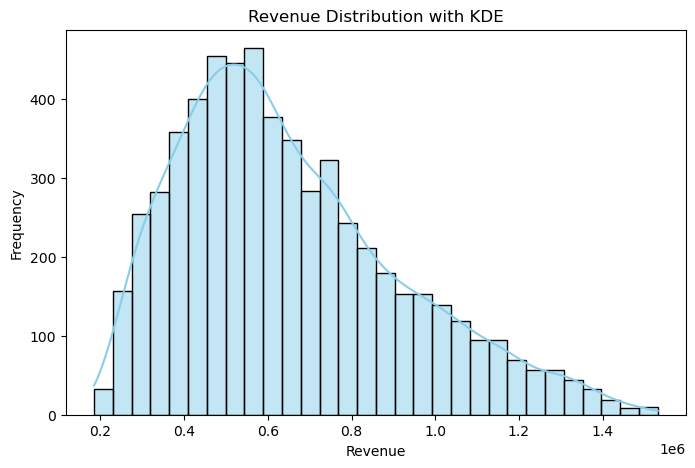

In [170]:
plt.figure(figsize=(8, 5))
sns.histplot(data=y_train, x='Revenue', kde=True, bins=30, color='skyblue')

plt.title('Revenue Distribution with KDE')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

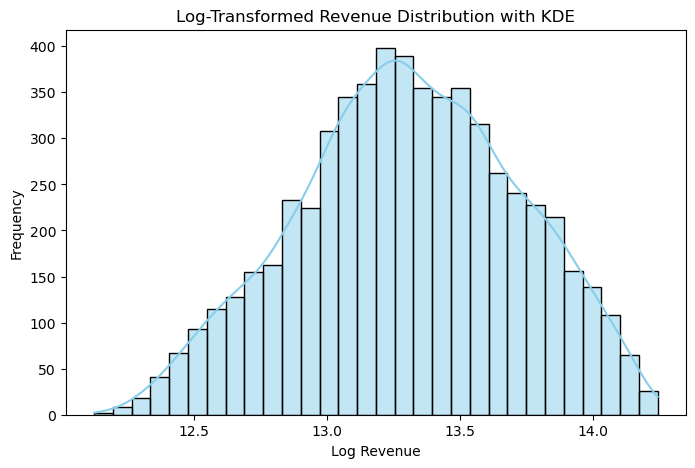

In [172]:
# Apply log transformation
y_train['Log_Revenue'] = np.log1p(y_train['Revenue'])  # log1p handles zero values safely

# Plot histogram with KDE
plt.figure(figsize=(8, 5))
sns.histplot(data=y_train, x='Log_Revenue', kde=True, bins=30, color='skyblue')

plt.title('Log-Transformed Revenue Distribution with KDE')
plt.xlabel('Log Revenue')
plt.ylabel('Frequency')
plt.show()

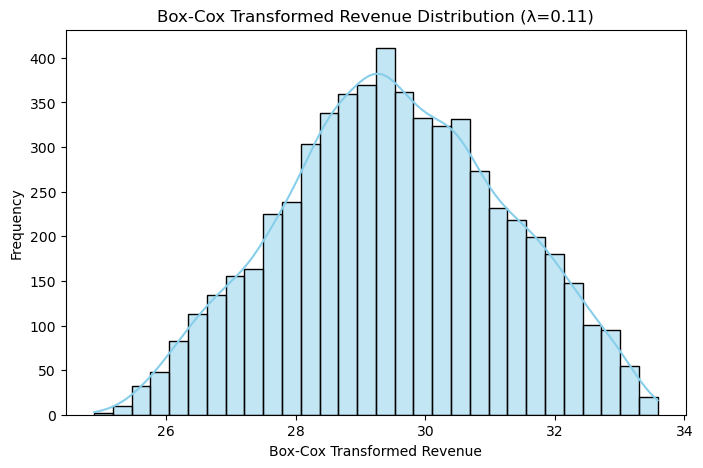

Optimal Lambda for Box-Cox Transformation: 0.11


In [174]:
# Apply Box-Cox transformation (requires positive values)
y_train['BoxCox_Revenue'], lambda_value = boxcox(y_train['Revenue'] + 1)  # Adding 1 to handle zero values

# Plot histogram with KDE
plt.figure(figsize=(8, 5))
sns.histplot(data=y_train, x='BoxCox_Revenue', kde=True, bins=30, color='skyblue')

plt.title(f'Box-Cox Transformed Revenue Distribution (λ={lambda_value:.2f})')
plt.xlabel('Box-Cox Transformed Revenue')
plt.ylabel('Frequency')
plt.show()

# Print the lambda value
print(f"Optimal Lambda for Box-Cox Transformation: {lambda_value:.2f}")

## Advanced Analysis

In [177]:
Train_df = df
Train_df

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category,clusters,Revenue
0,Rural,Japanese,49,3259,34243,6,109,4.2,5.5,Yes,24,11,810.583476,High,nonurban,794650.87
1,Suburban,Indian,55,2662,34744,4,826,1.8,4.6,Yes,27,24,500.508350,Medium,nonurban,421854.52
2,Suburban,Italian,60,1515,19829,13,207,8.5,3.5,Yes,44,51,699.115449,Medium,nonurban,659678.50
3,Downtown,Italian,90,5031,58655,13,805,3.5,9.6,Yes,86,29,817.414508,Medium,urban,958061.50
4,Rural,Italian,35,1778,24218,1,234,5.6,5.8,No,0,7,576.446525,Medium,nonurban,358587.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,Rural,Japanese,38,1925,19376,1,594,3.6,6.0,Yes,16,32,420.636825,High,nonurban,615576.80
5853,Suburban,French,68,2846,33561,19,278,5.9,1.1,No,60,0,879.088122,Medium,nonurban,926123.05
5854,Suburban,Italian,70,2521,26638,8,149,5.8,2.6,No,30,65,255.660252,Medium,nonurban,741198.15
5855,Rural,Italian,39,1198,15383,13,106,3.9,9.6,No,21,12,930.064661,Medium,nonurban,451999.81


In [179]:
# Apply log transformation
Train_df['Log_Revenue'] = np.log1p(Train_df['Revenue'])

In [181]:
Train_df

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category,clusters,Revenue,Log_Revenue
0,Rural,Japanese,49,3259,34243,6,109,4.2,5.5,Yes,24,11,810.583476,High,nonurban,794650.87,13.585659
1,Suburban,Indian,55,2662,34744,4,826,1.8,4.6,Yes,27,24,500.508350,Medium,nonurban,421854.52,12.952418
2,Suburban,Italian,60,1515,19829,13,207,8.5,3.5,Yes,44,51,699.115449,Medium,nonurban,659678.50,13.399509
3,Downtown,Italian,90,5031,58655,13,805,3.5,9.6,Yes,86,29,817.414508,Medium,urban,958061.50,13.772668
4,Rural,Italian,35,1778,24218,1,234,5.6,5.8,No,0,7,576.446525,Medium,nonurban,358587.50,12.789931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,Rural,Japanese,38,1925,19376,1,594,3.6,6.0,Yes,16,32,420.636825,High,nonurban,615576.80,13.330317
5853,Suburban,French,68,2846,33561,19,278,5.9,1.1,No,60,0,879.088122,Medium,nonurban,926123.05,13.738763
5854,Suburban,Italian,70,2521,26638,8,149,5.8,2.6,No,30,65,255.660252,Medium,nonurban,741198.15,13.516025
5855,Rural,Italian,39,1198,15383,13,106,3.9,9.6,No,21,12,930.064661,Medium,nonurban,451999.81,13.021439


In [183]:
Train_df_x = Train_df.drop(['Revenue', 'Log_Revenue'], axis=1)
Train_df_x

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category,clusters
0,Rural,Japanese,49,3259,34243,6,109,4.2,5.5,Yes,24,11,810.583476,High,nonurban
1,Suburban,Indian,55,2662,34744,4,826,1.8,4.6,Yes,27,24,500.508350,Medium,nonurban
2,Suburban,Italian,60,1515,19829,13,207,8.5,3.5,Yes,44,51,699.115449,Medium,nonurban
3,Downtown,Italian,90,5031,58655,13,805,3.5,9.6,Yes,86,29,817.414508,Medium,urban
4,Rural,Italian,35,1778,24218,1,234,5.6,5.8,No,0,7,576.446525,Medium,nonurban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,Rural,Japanese,38,1925,19376,1,594,3.6,6.0,Yes,16,32,420.636825,High,nonurban
5853,Suburban,French,68,2846,33561,19,278,5.9,1.1,No,60,0,879.088122,Medium,nonurban
5854,Suburban,Italian,70,2521,26638,8,149,5.8,2.6,No,30,65,255.660252,Medium,nonurban
5855,Rural,Italian,39,1198,15383,13,106,3.9,9.6,No,21,12,930.064661,Medium,nonurban


In [185]:
Train_df_y = Train_df['Log_Revenue']
Train_df_y

0       13.585659
1       12.952418
2       13.399509
3       13.772668
4       12.789931
          ...    
5852    13.330317
5853    13.738763
5854    13.516025
5855    13.021439
5856    12.338692
Name: Log_Revenue, Length: 5857, dtype: float64

In [187]:
Test_x = pd.read_csv("X_test.csv")
Test_x

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category
0,Downtown,Japanese,86,9065,96518,18,696,9.8,5.7,Yes,8,72,916.451777,High
1,Suburban,Mexican,64,2695,33408,13,200,1.3,2.8,No,15,47,246.711479,Low
2,Rural,American,33,2040,28686,13,281,9.9,9.0,Yes,10,26,1040.465868,Medium
3,Rural,American,49,2137,23569,18,376,6.0,1.5,No,20,38,659.340288,Medium
4,Suburban,Italian,51,1304,15045,11,280,1.2,3.0,No,10,13,591.269321,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,Downtown,Indian,87,5057,51442,4,192,1.7,2.1,Yes,70,86,351.636262,Medium
2507,Suburban,French,63,1696,25010,10,389,5.6,2.3,Yes,40,40,454.949648,High
2508,Downtown,Italian,80,3388,41761,10,234,1.2,8.6,Yes,44,15,794.682576,Medium
2509,Suburban,Indian,67,4040,49738,12,745,8.6,2.5,No,34,47,468.604272,Medium


In [189]:
Test_y = pd.read_csv("y_test.csv")
Test_y = np.log1p(Test_y)

In [191]:
Test_y

,Revenue
0,14.063469
1,12.979991
2,12.647958
3,13.139236
4,13.275977
...,...
2506,13.467979
2507,13.699288
2508,13.656687
2509,13.073093


## Advance Analysis

### Encode, Transform

In [163]:
## Encode Ordinal columns

## Train set
Train_df_x['Location'] = Train_df_x['Location'].astype(str)
encoder = OrdinalEncoder(categories=[['Rural', 'Suburban', 'Downtown']])
Train_df_x[['Location']] = encoder.fit_transform(Train_df_x[['Location']])
Train_df_x['Location'] = Train_df_x['Location'].astype(int)

encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
Train_df_x[["Meal Price Category"]] = encoder.fit_transform(Train_df_x[["Meal Price Category"]])
Train_df_x["Meal Price Category"] = Train_df_x["Meal Price Category"].astype(int)

## Test set

encoder = OrdinalEncoder(categories=[['Rural', 'Suburban', 'Downtown']])
Test_x[['Location']] = encoder.fit_transform(Test_x[['Location']])
Test_x['Location'] = Test_x['Location'].astype(int)

encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
Test_x[["Meal Price Category"]] = encoder.fit_transform(Test_x[["Meal Price Category"]])
Test_x["Meal Price Category"] = Test_x["Meal Price Category"].astype(int)

In [165]:
Train_df_x

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category,clusters
0,0,Japanese,49,3259,34243,6,109,4.2,5.5,Yes,24,11,810.583476,2,nonurban
1,1,Indian,55,2662,34744,4,826,1.8,4.6,Yes,27,24,500.508350,1,nonurban
2,1,Italian,60,1515,19829,13,207,8.5,3.5,Yes,44,51,699.115449,1,nonurban
3,2,Italian,90,5031,58655,13,805,3.5,9.6,Yes,86,29,817.414508,1,urban
4,0,Italian,35,1778,24218,1,234,5.6,5.8,No,0,7,576.446525,1,nonurban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,0,Japanese,38,1925,19376,1,594,3.6,6.0,Yes,16,32,420.636825,2,nonurban
5853,1,French,68,2846,33561,19,278,5.9,1.1,No,60,0,879.088122,1,nonurban
5854,1,Italian,70,2521,26638,8,149,5.8,2.6,No,30,65,255.660252,1,nonurban
5855,0,Italian,39,1198,15383,13,106,3.9,9.6,No,21,12,930.064661,1,nonurban


In [167]:
Test_x

,Location,Cuisine,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Parking Availability,Weekend Reservations,Weekday Reservations,Review Quality Score,Meal Price Category
0,2,Japanese,86,9065,96518,18,696,9.8,5.7,Yes,8,72,916.451777,2
1,1,Mexican,64,2695,33408,13,200,1.3,2.8,No,15,47,246.711479,0
2,0,American,33,2040,28686,13,281,9.9,9.0,Yes,10,26,1040.465868,1
3,0,American,49,2137,23569,18,376,6.0,1.5,No,20,38,659.340288,1
4,1,Italian,51,1304,15045,11,280,1.2,3.0,No,10,13,591.269321,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,2,Indian,87,5057,51442,4,192,1.7,2.1,Yes,70,86,351.636262,1
2507,1,French,63,1696,25010,10,389,5.6,2.3,Yes,40,40,454.949648,2
2508,2,Italian,80,3388,41761,10,234,1.2,8.6,Yes,44,15,794.682576,1
2509,1,Indian,67,4040,49738,12,745,8.6,2.5,No,34,47,468.604272,1


In [169]:
## Drop cluster column

Train_df_x.drop(columns=["clusters"], inplace=True)


In [171]:
categorical_cols = ['Cuisine', 'Parking Availability'] 
ordinal_categorical = ['Location', 'Meal Price Category','Cuisine', 'Parking Availability']
numerical_cols = [col for col in Train_df_x.columns if col not in ordinal_categorical]
numerical_cols = [col for col in Test_x.columns if col not in ordinal_categorical]

In [173]:
# Initialize encoder 
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform
encoded_cats = encoder.fit_transform(Train_df_x[categorical_cols])
encoded_cats_test = encoder.transform(Test_x[categorical_cols])  # Use transform() for test set

# Convert to DataFrame correctly
encoded_df = pd.DataFrame(
    encoded_cats,
    columns=encoder.get_feature_names_out()
)

encoded_df_test = pd.DataFrame(
    encoded_cats_test,
    columns=encoder.get_feature_names_out()
)


In [175]:
# Scale numerical features (critical for distance calculations)

scaler = StandardScaler()
Train_df_x[numerical_cols] = scaler.fit_transform(Train_df_x[numerical_cols])
Test_x[numerical_cols] = scaler.fit_transform(Test_x[numerical_cols])

In [177]:
# Combine categorical features with numerical features

Train_df_x1 = pd.concat([Train_df_x[numerical_cols].reset_index(drop=True),
    encoded_df], axis=1)

Test_df_x1 = pd.concat([Test_x[numerical_cols].reset_index(drop=True),
    encoded_df_test], axis=1)

In [179]:
## Add meal price category 

Train_df_x1['Meal Price Category'] = Train_df_x['Meal Price Category'].values
Test_df_x1['Meal Price Category'] = Test_x['Meal Price Category'].values

Train_df_x1['Location'] = Train_df_x['Location'].values
Test_df_x1['Location'] = Test_x['Location'].values

In [181]:
Train_df_x1

,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Weekend Reservations,Weekday Reservations,Review Quality Score,Cuisine_French,Cuisine_Indian,Cuisine_Italian,Cuisine_Japanese,Cuisine_Mexican,Parking Availability_Yes,Meal Price Category,Location
0,-0.634164,0.022924,-0.106408,-0.722542,-1.504662,-0.520297,0.012226,-0.278235,-0.919097,0.348328,0.0,0.0,0.0,1.0,0.0,1.0,2,0
1,-0.288299,-0.305758,-0.079374,-1.085253,1.084756,-1.454932,-0.335381,-0.127228,-0.265472,-0.655155,0.0,1.0,0.0,0.0,0.0,1.0,1,1
2,-0.000079,-0.937244,-0.884174,0.546946,-1.150739,1.154258,-0.760234,0.728483,1.092055,-0.012411,0.0,0.0,1.0,0.0,0.0,1.0,1,1
3,1.729245,0.998507,1.210842,0.546946,1.008916,-0.792899,1.595768,2.842591,-0.014078,0.370435,0.0,0.0,1.0,0.0,0.0,1.0,1,2
4,-1.441182,-0.792448,-0.647348,-1.629319,-1.053229,0.024907,0.128095,-1.486297,-1.120212,-0.409400,0.0,0.0,1.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5852,-1.268250,-0.711517,-0.908618,-1.629319,0.246897,-0.753956,0.205341,-0.680923,0.136758,-0.913640,0.0,0.0,0.0,1.0,0.0,1.0,2,0
5853,0.461074,-0.204456,-0.143208,1.635079,-0.894325,0.141737,-1.687185,1.533857,-1.472163,0.570027,1.0,0.0,0.0,0.0,0.0,0.0,1,1
5854,0.576363,-0.383386,-0.516767,-0.359831,-1.360204,0.102793,-1.107840,0.023780,1.795958,-1.447547,0.0,0.0,1.0,0.0,0.0,0.0,1,1
5855,-1.210605,-1.111770,-1.124076,0.546946,-1.515497,-0.637126,1.595768,-0.429243,-0.868818,0.735000,0.0,0.0,1.0,0.0,0.0,0.0,1,0


In [183]:
Test_df_x1

,Seating Capacity,Marketing Budget,Social Media Followers,Chef Experience Years,Number of Reviews,Ambience Score,Service Quality Score,Weekend Reservations,Weekday Reservations,Review Quality Score,Cuisine_French,Cuisine_Indian,Cuisine_Italian,Cuisine_Japanese,Cuisine_Mexican,Parking Availability_Yes,Meal Price Category,Location
0,1.444867,3.169013,3.203061,1.411627,0.644737,1.663869,0.037607,-1.050089,2.115308,0.722661,0.0,0.0,0.0,1.0,0.0,1.0,2,2
1,0.188158,-0.284840,-0.144586,0.505544,-1.140680,-1.615152,-1.087495,-0.706733,0.881719,-1.459776,0.0,0.0,0.0,0.0,1.0,0.0,0,1
2,-1.582659,-0.639985,-0.395063,0.505544,-0.849110,1.702446,1.317896,-0.951987,-0.154496,1.126778,0.0,0.0,0.0,0.0,0.0,1.0,1,0
3,-0.668689,-0.587391,-0.666492,1.411627,-0.507145,0.197953,-1.591852,-0.461480,0.437627,-0.115170,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,-0.554442,-1.039049,-1.118645,0.143111,-0.852709,-1.653729,-1.009902,-0.951987,-0.795962,-0.336989,0.0,0.0,1.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,1.501990,0.995851,0.812021,-1.125404,-1.169477,-1.460846,-1.359072,1.991059,2.806118,-1.117865,0.0,1.0,0.0,0.0,0.0,1.0,1,2
2507,0.131035,-0.826504,-0.590055,-0.038105,-0.460350,0.043647,-1.281479,0.519536,0.536314,-0.781204,1.0,0.0,0.0,0.0,0.0,1.0,2,1
2508,1.102128,0.090909,0.298496,-0.038105,-1.018292,-1.653729,1.162709,0.715739,-0.697275,0.325860,0.0,0.0,1.0,0.0,0.0,1.0,1,2
2509,0.359528,0.444427,0.721633,0.324328,0.821118,1.200948,-1.203885,0.225231,0.881719,-0.736709,0.0,1.0,0.0,0.0,0.0,0.0,1,1


In [185]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

### Lasso Regression

In [188]:
# LASSO REGRESSION

param_grid_lasso = {
    'alpha': np.logspace(-4, 2, 50)
}

lasso_model_tuned = Lasso(max_iter=5000)
grid_search_lasso = GridSearchCV(lasso_model_tuned, param_grid_lasso, cv=10, scoring='neg_mean_squared_error')
grid_search_lasso.fit(Train_df_x1, Train_df_y)

best_params_lasso = grid_search_lasso.best_params_
best_score_lasso = grid_search_lasso.best_score_

print("Best parameters for Lasso Regression:", best_params_lasso)
print("Best score for Lasso Regression:", best_score_lasso)

Best parameters for Lasso Regression: {'alpha': 0.0001}
Best score for Lasso Regression: -0.005367089731137818


In [190]:
lasso_model_best = Lasso(**best_params_lasso,max_iter=5000)
lasso_model_best.fit(Train_df_x1, Train_df_y)

# Predictions on the training set
lasso_train_predictions = lasso_model_best.predict(Train_df_x1)

# Predictions on the test set
lasso_test_predictions = lasso_model_best.predict(Test_df_x1)

In [192]:
# MSE for training and test sets
lasso_train_mse = mean_squared_error(Train_df_y, lasso_train_predictions)
lasso_test_mse = mean_squared_error(Test_y, lasso_test_predictions)

# RMSE for training and test sets
lasso_train_rmse = root_mean_squared_error(Train_df_y, lasso_train_predictions)
lasso_test_rmse = root_mean_squared_error(Test_y, lasso_test_predictions)

# MAE for training and test sets
lasso_train_mae = mean_absolute_error(Train_df_y, lasso_train_predictions)
lasso_test_mae = mean_absolute_error(Test_y, lasso_test_predictions)

# R² for training and test sets
lasso_train_r2 = r2_score(Train_df_y, lasso_train_predictions)
lasso_test_r2 = r2_score(Test_y, lasso_test_predictions)

# MSE Difference (Overfitting Indicator)
lasso_mse_difference = lasso_train_mse - lasso_test_mse

print("Lasso Regression Train MSE:", lasso_train_mse)
print("Lasso Regression Train RMSE:", lasso_train_rmse)
print("Lasso Regression Train MAE:", lasso_train_mae)
print("Lasso Regression Train R²:", lasso_train_r2)

print("Lasso Regression Test MSE:", lasso_test_mse)
print("Lasso Regression Test RMSE:", lasso_test_rmse)
print("Lasso Regression Test MAE:", lasso_test_mae)
print("Lasso Regression Test R²:", lasso_test_r2)
print("Lasso Regression Train-Test mse difference", lasso_mse_difference)

Lasso Regression Train MSE: 0.005332854914949275
Lasso Regression Train RMSE: 0.07302639875380186
Lasso Regression Train MAE: 0.059310167807880614
Lasso Regression Train R²: 0.9686418880767861
Lasso Regression Test MSE: 0.005421156457176091
Lasso Regression Test RMSE: 0.07362850302142568
Lasso Regression Test MAE: 0.06027944053879027
Lasso Regression Test R²: 0.967552322577905
Lasso Regression Train-Test mse difference -8.830154222681623e-05


### Elastic Net Regression

In [195]:
# Define parameter grid for Elastic Net (Grid Search)
param_grid_elasticnet = {
    'alpha': np.logspace(-4, 2, 50),  
    'l1_ratio': np.linspace(0.1, 0.9, 9)   # Ratio of L1 (Lasso) to L2 (Ridge) penalty
}

# Initialize Elastic Net model
elasticnet_model_tuned = ElasticNet()

# Perform Grid Search with cross-validation (cv=5)
grid_search_elasticnet = GridSearchCV(
    elasticnet_model_tuned, 
    param_grid_elasticnet, 
    cv=10, 
    scoring='neg_mean_squared_error'
)

# Fit Grid Search on training data
grid_search_elasticnet.fit(Train_df_x1, Train_df_y)

# Extract best parameters and best score
best_params_elasticnet = grid_search_elasticnet.best_params_
best_score_elasticnet = grid_search_elasticnet.best_score_

# Print best parameters and score
print("Best parameters for Elastic Net Regression:", best_params_elasticnet)
print("Best score for Elastic Net Regression:", best_score_elasticnet)

Best parameters for Elastic Net Regression: {'alpha': 0.0001, 'l1_ratio': 0.4}
Best score for Elastic Net Regression: -0.0053668360967239455


In [197]:
# Train the Best Elastic Net Model
# Initialize best Elastic Net model with optimal parameters
elasticnet_model_best = ElasticNet(**best_params_elasticnet)

# Train the model on scaled training data
elasticnet_model_best.fit(Train_df_x1, Train_df_y)

# Predictions and Error Metrics
# Predictions on the training set
elasticnet_train_predictions = elasticnet_model_best.predict(Train_df_x1)

# Predictions on the test set
elasticnet_test_predictions = elasticnet_model_best.predict(Test_df_x1)


In [199]:
# Compute Performance Metrics

# Mean Squared Error (MSE)
elasticnet_train_mse = mean_squared_error(Train_df_y, elasticnet_train_predictions)
elasticnet_test_mse = mean_squared_error(Test_y, elasticnet_test_predictions)

# Root Mean Squared Error (RMSE)
elasticnet_train_rmse = root_mean_squared_error(Train_df_y, elasticnet_train_predictions)
elasticnet_test_rmse = root_mean_squared_error(Test_y, elasticnet_test_predictions)

# Mean Absolute Error (MAE)
elasticnet_train_mae = mean_absolute_error(Train_df_y, elasticnet_train_predictions)
elasticnet_test_mae = mean_absolute_error(Test_y, elasticnet_test_predictions)

# R² Score (Coefficient of Determination)
elasticnet_train_r2 = r2_score(Train_df_y, elasticnet_train_predictions)
elasticnet_test_r2 = r2_score(Test_y, elasticnet_test_predictions)

# MSE Difference (Overfitting Indicator)
elasticnet_mse_difference = elasticnet_train_mse - elasticnet_test_mse


In [201]:
print("Elastic Net Regression Train MSE:", elasticnet_train_mse)
print("Elastic Net Regression Test MSE:", elasticnet_test_mse)
print("Elastic Net Regression Train RMSE:", elasticnet_train_rmse)
print("Elastic Net Regression Test RMSE:", elasticnet_test_rmse)
print("Elastic Net Regression Train MAE:", elasticnet_train_mae)
print("Elastic Net Regression Test MAE:", elasticnet_test_mae)
print("Elastic Net Regression Train R²:", elasticnet_train_r2)
print("Elastic Net Regression Test R²:", elasticnet_test_r2)
print("Elastic Net Train-Test MSE Difference:", elasticnet_mse_difference)

Elastic Net Regression Train MSE: 0.005332171312336307
Elastic Net Regression Test MSE: 0.005421801720360053
Elastic Net Regression Train RMSE: 0.07302171808671928
Elastic Net Regression Test RMSE: 0.07363288477548638
Elastic Net Regression Train MAE: 0.059308211520115346
Elastic Net Regression Test MAE: 0.06027860564093378
Elastic Net Regression Train R²: 0.9686459077787263
Elastic Net Regression Test R²: 0.9675484604330267
Elastic Net Train-Test MSE Difference: -8.963040802374613e-05


### Ridge Regression

In [204]:
# Define hyperparameter grid
param_grid_ridge = {
    'alpha': np.logspace(-4, 2, 50)  # Regularization strength
}

# Perform Grid Search for best hyperparameters
ridge_model_tuned = Ridge()
grid_search_ridge = GridSearchCV(ridge_model_tuned, param_grid_ridge, cv=10, scoring='neg_mean_squared_error')
grid_search_ridge.fit(Train_df_x1, Train_df_y)

# Get best parameters & score
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

print("Best parameters for Ridge Regression:", best_params_ridge)
print("Best score for Ridge Regression:", best_score_ridge)

Best parameters for Ridge Regression: {'alpha': 0.028117686979742307}
Best score for Ridge Regression: -0.00536714724727849


In [205]:
# Fit model with best parameters
ridge_model_best = Ridge(**best_params_ridge)
ridge_model_best.fit(Train_df_x1, Train_df_y)

# Predictions on the training set
ridge_train_predictions = ridge_model_best.predict(Train_df_x1)

# Predictions on the test set
ridge_test_predictions = ridge_model_best.predict(Test_df_x1)

In [206]:
# Compute Performance Metrics
ridge_train_mse = mean_squared_error(Train_df_y, ridge_train_predictions)
ridge_test_mse = mean_squared_error(Test_y, ridge_test_predictions)

ridge_train_rmse = root_mean_squared_error(Train_df_y, ridge_train_predictions)
ridge_test_rmse = root_mean_squared_error(Test_y, ridge_test_predictions)

ridge_train_mae = mean_absolute_error(Train_df_y, ridge_train_predictions)
ridge_test_mae = mean_absolute_error(Test_y, ridge_test_predictions)

ridge_train_r2 = r2_score(Train_df_y, ridge_train_predictions)
ridge_test_r2 = r2_score(Test_y, ridge_test_predictions)

# MSE Difference (Overfitting Indicator)
ridge_mse_difference = ridge_train_mse - ridge_test_mse

# Print results
print("Ridge Regression Train MSE:", ridge_train_mse)
print("Ridge Regression Test MSE:", ridge_test_mse)
print("Ridge Regression Train RMSE:", ridge_train_rmse)
print("Ridge Regression Test RMSE:", ridge_test_rmse)
print("Ridge Regression Train MAE:", ridge_train_mae)
print("Ridge Regression Test MAE:", ridge_test_mae)
print("Ridge Regression Train R²:", ridge_train_r2)
print("Ridge Regression Test R²:", ridge_test_r2)
print("Ridge Train-Test MSE Difference:", ridge_mse_difference)

Ridge Regression Train MSE: 0.005331867811043477
Ridge Regression Test MSE: 0.005423176976034615
Ridge Regression Train RMSE: 0.07301963989943717
Ridge Regression Test RMSE: 0.07364222278037658
Ridge Regression Train MAE: 0.05930289182892594
Ridge Regression Test MAE: 0.06027359660301836
Ridge Regression Train R²: 0.9686476924189726
Ridge Regression Test R²: 0.9675402290062355
Ridge Train-Test MSE Difference: -9.13091649911383e-05


### Random Forest Model

In [211]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}

# Perform Grid Search for best hyperparameters
rf_model_tuned = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf_model_tuned, param_grid_rf, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(Train_df_x1, Train_df_y)

# Get best parameters & score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best parameters for Random Forest:", best_params_rf)
print("Best score for Random Forest:", best_score_rf)

# Fit model with best parameters
rf_model_best = RandomForestRegressor(**best_params_rf, random_state=42)
rf_model_best.fit(Train_df_x1, Train_df_y)

# Predictions on the training set
rf_train_predictions = rf_model_best.predict(Train_df_x1)

# Predictions on the test set
rf_test_predictions = rf_model_best.predict(Test_df_x1)

# Compute Performance Metrics
rf_train_mse = mean_squared_error(Train_df_y, rf_train_predictions)
rf_test_mse = mean_squared_error(Test_y, rf_test_predictions)

rf_train_rmse = np.sqrt(rf_train_mse)
rf_test_rmse = np.sqrt(rf_test_mse)

rf_train_mae = mean_absolute_error(Train_df_y, rf_train_predictions)
rf_test_mae = mean_absolute_error(Test_y, rf_test_predictions)

rf_train_r2 = r2_score(Train_df_y, rf_train_predictions)
rf_test_r2 = r2_score(Test_y, rf_test_predictions)

# MSE Difference (Overfitting Indicator)
rf_mse_difference = rf_train_mse - rf_test_mse

# Print results
print("Random Forest Train MSE:", rf_train_mse)
print("Random Forest Test MSE:", rf_test_mse)
print("Random Forest Train RMSE:", rf_train_rmse)
print("Random Forest Test RMSE:", rf_test_rmse)
print("Random Forest Train MAE:", rf_train_mae)
print("Random Forest Test MAE:", rf_test_mae)
print("Random Forest Train R²:", rf_train_r2)
print("Random Forest Test R²:", rf_test_r2)
print("Random Forest Train-Test MSE Difference:", rf_mse_difference)


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best score for Random Forest: -0.003991536798417006
Random Forest Train MSE: 0.0021999412468098637
Random Forest Test MSE: 0.00418930747609675
Random Forest Train RMSE: 0.04690353128294141
Random Forest Test RMSE: 0.06472485979974581
Random Forest Train MAE: 0.036947036608244235
Random Forest Test MAE: 0.052662921120902095
Random Forest Train R²: 0.9870639638726015
Random Forest Test R²: 0.9749254059202772
Random Forest Train-Test MSE Difference: -0.0019893662292868866


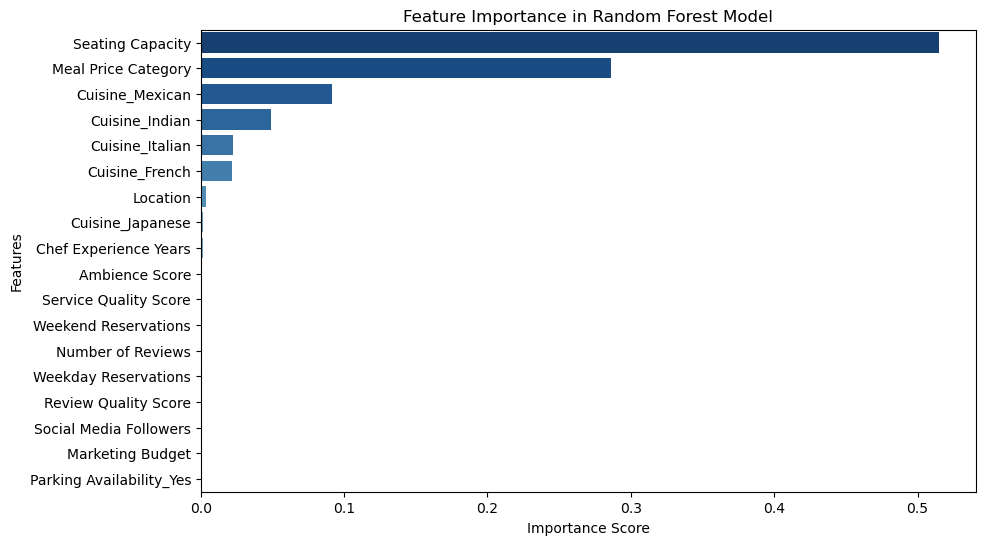

In [223]:
# Get feature importances
feature_importance = rf_model_best.feature_importances_

# Create a DataFrame for better visualization
feature_names = Train_df_x1.columns  # Column names of the dataset
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort by importance (descending)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

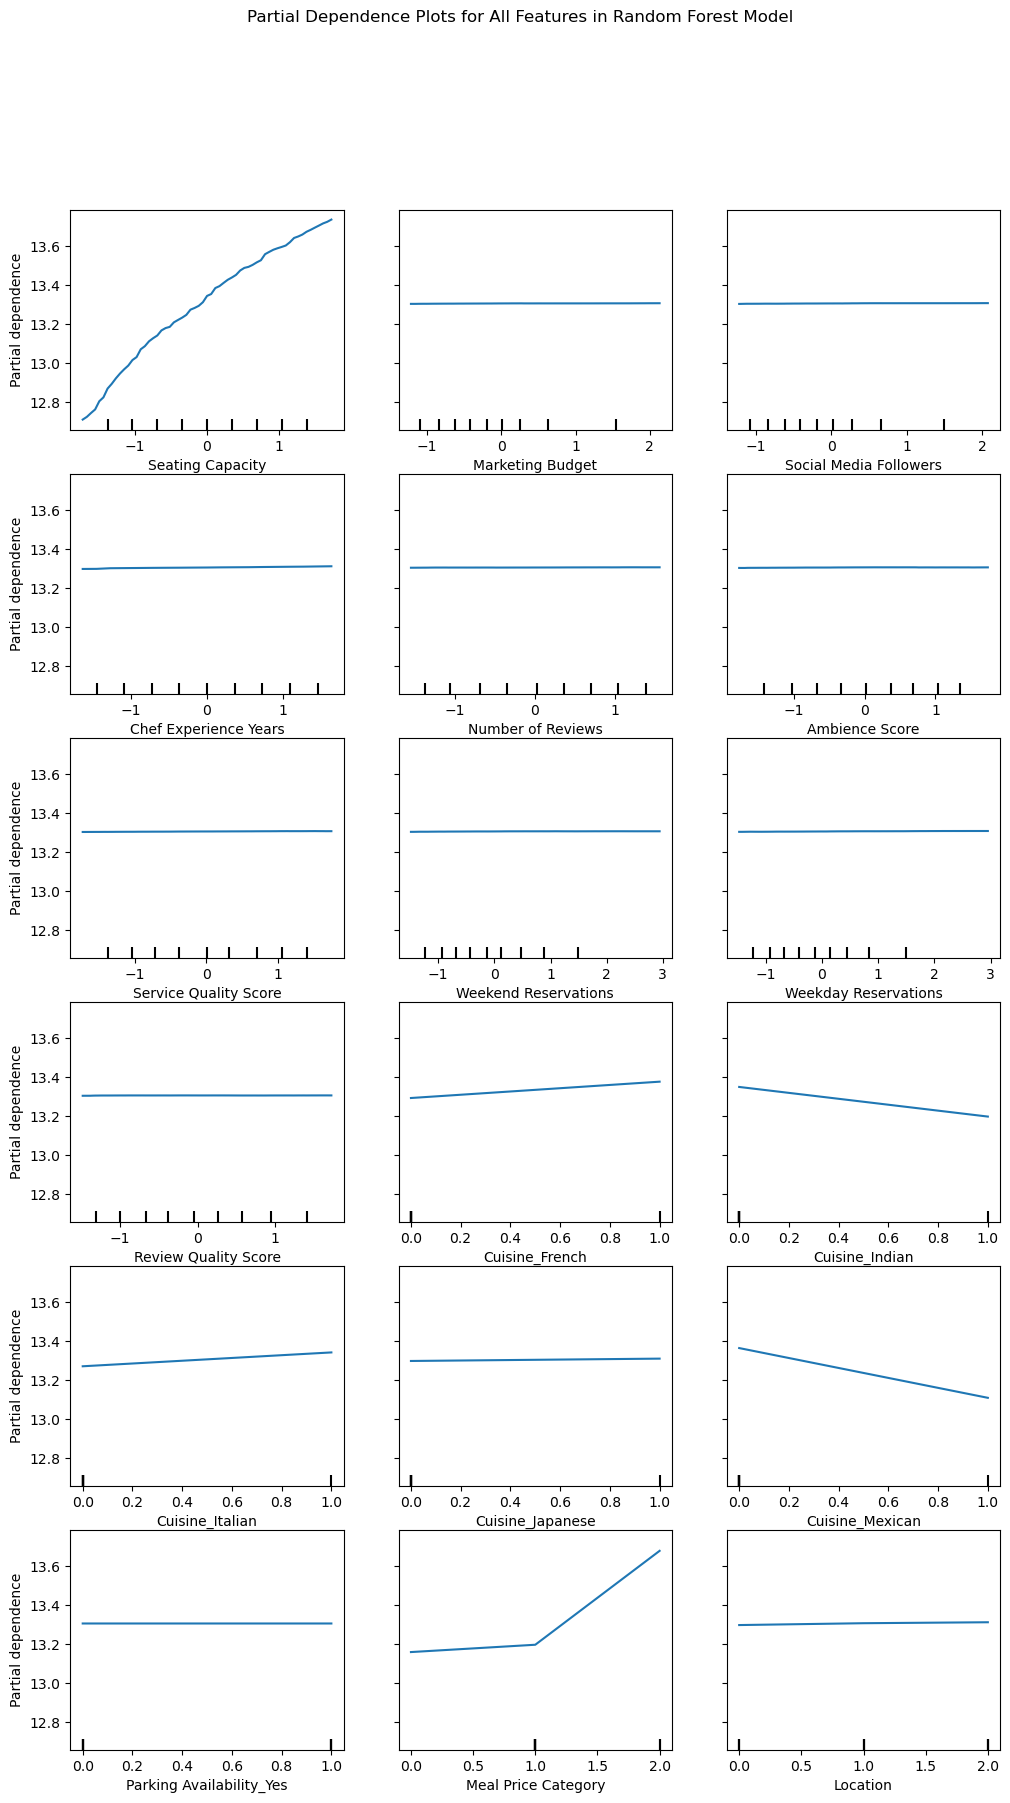

In [224]:
from sklearn.inspection import PartialDependenceDisplay

# Get all feature names from the dataset
features = Train_df_x1.columns.tolist()

# Create PDP for all features
fig, ax = plt.subplots(figsize=(12, 20))
PartialDependenceDisplay.from_estimator(rf_model_best, Train_df_x1, features, n_cols=3, ax=ax)

plt.suptitle('Partial Dependence Plots for All Features in Random Forest Model')
plt.show()